In [2]:
import sys, ftplib, os, requests, iris, metpy.calc, math
from metpy.units import units
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("/Users/jago/Downloads")
import netCDF4 as nc
from datetime import datetime,timedelta
import scipy.interpolate
import numpy as np
import time as time_mod

save_dir = "data/wind/radar/capel-dewi/"
forcast_dir = "data/wind/gfs/"

radar_lat=52.42
radar_long=-4.01
sample_point=[('latitude', radar_lat),('longitude', radar_long)]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Notes
## Radar data
- Descriptor says the 7 day variability is "1.0 - 3.0 m/s for altitudes between 2 and 15 km and in the range 3.0 - 4.0 m/s between 15 and 20 km"

## GFS
- Only until May 2020 is available in the usual archive
- Only 0.5 degree is available so the difference in difference profile between 0.25 and 0.5 degrees will need to be validated with the last few days of data at some point (prehaps downloading them from now on would be a good idea)
- x wind is 168, y wind 180 and geopotential 122

In [3]:
def daterange(start_date, end_date):
#https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
    for n in range(int((end_date - start_date).days+1)):
        yield start_date + timedelta(n)

In [4]:
start_date="20201201"
end_date="20201210"

start_dt = datetime.strptime(start_date, "%Y%m%d")
end_dt = datetime.strptime(end_date, "%Y%m%d")

uname="jagosw"
pwd="ftBr7AaY"

runs=["0000","0600","1200","1800"]
forcast_distance="003"

In [5]:
f=ftplib.FTP("ftp.ceda.ac.uk", uname, pwd)

for day in daterange(start_dt, end_dt):
    year = day.strftime("%Y")
    month = day.strftime("%m")
    date = day.strftime("%Y%m%d")
    file="radar-mst_capel-dewi_%s_st300_cartesian_v3.nc"%date
    if not os.path.isfile("%s%s.nc"%(save_dir,date)):
        f.cwd("/badc/mst/data/mst-products-v3/m-mode/cartesian/%s/%s"%(year, month))
        f.retrbinary("RETR %s" % file, open("%s%s_m.nc"%(save_dir,date), "wb").write)

error_perm: 530 Login incorrect.

In [5]:
tst=time_mod.time()
n_measured=pd.DataFrame()
e_measured=pd.DataFrame()
alts=[]
for day in daterange(start_dt, end_dt):
    date = day.strftime("%Y%m%d")
    data = nc.Dataset("%s%s.nc"%(save_dir,date))
    alts=data["altitude"][:]
    for index,time in enumerate(data["time"][:]):
        n_measured.insert(0,day.timestamp()+time,data["northward_wind"][index][:])
        e_measured.insert(0,day.timestamp()+time,data["northward_wind"][index][:])
print(time_mod.time()-tst)

4.883520126342773


In [6]:
n_measured

,1.607645e+09,1.607644e+09,1.607644e+09,1.607644e+09,1.607643e+09,1.607643e+09,1.607643e+09,1.607642e+09,1.607642e+09,1.607642e+09,...,1.606784e+09,1.606783e+09,1.606783e+09,1.606783e+09,1.606782e+09,1.606782e+09,1.606782e+09,1.606781e+09,1.606781e+09,1.606781e+09
0,2.876337,7.077095,6.761139,5.139163,3.241069,5.961728,5.240764,7.832899,5.692378,6.172660,...,-7.967781,-6.751612,-6.213647,-11.887053,-10.946968,-12.190286,-8.360106,-9.387648,-14.877710,-11.721119
1,3.196157,6.763461,7.320036,6.606240,4.691553,4.398917,5.180660,8.158134,3.176749,5.042767,...,-10.228003,-5.508870,-9.423129,-8.518347,-6.357596,-12.002102,-8.860939,-12.716741,-14.633698,-10.465627
2,4.516661,10.133300,8.343271,7.521155,6.263145,4.789653,5.868382,7.490597,4.096327,4.078561,...,-13.428343,-14.777451,-6.678818,-11.086853,-9.896766,-12.644575,-8.743855,-11.638307,-14.284716,-13.804766
3,4.175746,8.750729,8.857790,7.346257,5.135475,6.369559,6.225154,8.890112,4.225566,4.496965,...,-12.687513,-14.402435,-9.032200,-12.148390,-13.854172,-13.775956,-13.469601,-13.986418,-14.483198,-16.932301
4,5.421283,6.685863,11.641452,8.627311,8.854197,5.460176,4.711686,8.452118,3.574124,4.305084,...,-13.532259,-14.598768,-10.738259,-11.780381,-13.601437,-12.792989,-12.138392,-15.438450,-14.990939,-12.984299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
126,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
127,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
128,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000


I don't think that interpolating both data sets is very good. Since we must interpolate the forcast it seems reasonable to interpolate it here but if the radar doesn't use the same altitude points every day then it would be very hard to hold the data.

Ideally/most efficiently we want to interpolate the forcast data for every point in the radar data

In [7]:
tst=time_mod.time()
n_interps=[]
e_interps=[]
for ind,a in enumerate(alts):
    n_interps.append(scipy.interpolate.interp1d(n_measured.columns.values.tolist(),n_measured.loc[ind].to_list(),fill_value="extrapolate"))
    e_interps.append(scipy.interpolate.interp1d(e_measured.columns.values.tolist(),e_measured.loc[ind].to_list(),fill_value="extrapolate"))
print(time_mod.time()-tst)

0.19969511032104492


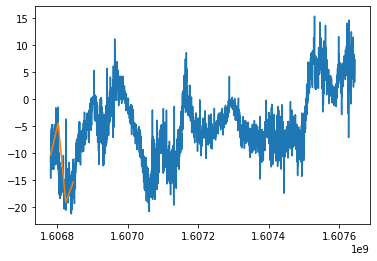

In [8]:
plt.plot(n_measured.columns.values.tolist(),n_measured.loc[1].to_list())
plt.plot([start_dt.timestamp(),start_dt.timestamp()+6*60*60,start_dt.timestamp()+12*60*60,start_dt.timestamp()+18*60*60],[n_interps[1](start_dt.timestamp()),n_interps[1](start_dt.timestamp()+6*60*60),n_interps[1](start_dt.timestamp()+12*60*60),n_interps[1](start_dt.timestamp()+18*60*60)])

In [9]:
tst=time_mod.time()
n_forcast=pd.DataFrame()
e_forcast=pd.DataFrame()
for day in daterange(start_dt, end_dt):
    for run in runs:
        ym=day.strftime("%Y%m")
        date=day.strftime("%Y%m%d")
        if not os.path.isfile("%s%s_%s_%s.grb2"%(forcast_dir, date,run,forcast_distance)):
            #this url will only work as far back as 18th May 2020
            url="https://www.ncei.noaa.gov/data/global-forecast-system/access/grid-004-0.5-degree/forecast/%s/%s/gfs_4_%s_%s_%s.grb2"%(ym,date,date,run,forcast_distance)
            r = requests.get(url, stream=True)
            with open("%s%s_%s_%s.grb2"%(forcast_dir, date,run,forcast_distance),'wb') as f:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
print(time_mod.time()-tst)  

0.0031027793884277344


In [10]:
tst=time_mod.time()
n_diffs=pd.DataFrame()
e_diffs=pd.DataFrame()
n_forcast=pd.DataFrame()
e_forcast=pd.DataFrame()
for day in daterange(start_dt, end_dt):
    for run in runs:
        date=day.strftime("%Y%m%d")
        data=iris.load("%s%s_%s_%s.grb2"%(forcast_dir, date,run,forcast_distance))

        e=data[168].interpolate(sample_point, iris.analysis.Linear())
        n=data[180].interpolate(sample_point, iris.analysis.Linear())
        geos=data[122].interpolate(sample_point, iris.analysis.Linear())

        row_n=[]
        row_nf=[]
        row_e=[]
        row_ef=[]
        for ind,alt in enumerate(alts):
            press=scipy.interpolate.interp1d(geos.data,geos.coord("pressure").points,fill_value="extrapolate")(alt)
            w_n=scipy.interpolate.interp1d(n.coord("pressure").points,n.data,fill_value=(n.data[0],n.data[-1]),bounds_error=False)(press)
            w_e=scipy.interpolate.interp1d(e.coord("pressure").points,e.data,fill_value=(e.data[0],e.data[-1]),bounds_error=False)(press)
            row_n.append(n_interps[ind](day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60)-w_n)
            row_e.append(e_interps[ind](day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60)+w_e)
            row_nf.append(n_interps[ind](day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60))
            row_ef.append(e_interps[ind](day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60))
        n_diffs.insert(0,day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60,row_n)
        e_diffs.insert(0,day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60,row_e)
        n_forcast.insert(0,day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60,row_nf)
        e_forcast.insert(0,day.timestamp()+(int(forcast_distance)+int(run)/100)*60*60,row_ef)
print(time_mod.time()-tst)          

159.19140005111694


# Need to check which direction wind goes in the sim since it seems that wind-x goes west and wind-y goes north which isn't even right handed

'ax.plot(alts,n_measured.mean(axis=1),label="nm")\nax.plot(alts,n_forcast.mean(axis=1),label="nf")\n#ax.plot(alts,e_measured.mean(axis=1),label="em")\n#ax.plot(alts,e_forcast.mean(axis=1),label="ef")\n\nax2.plot(alts,n_diffs.mean(axis=1),label="n")\n#ax2.plot(alts,e_diffs.mean(axis=1),label="e")\nax2.plot(alts,n_measured.mean(axis=1)-n_forcast.mean(axis=1),label="nm")\n#ax2.plot(alts,e_measured.mean(axis=1)-e_forcast.mean(axis=1),label="em")\nax.legend()\nax2.legend()'

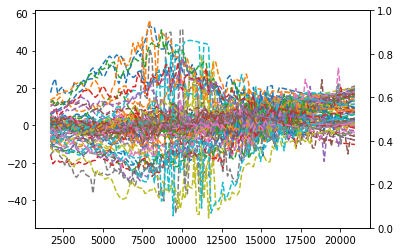

In [290]:
fig,ax=plt.subplots()
ax2=ax.twinx()
ax.plot(alts,n_diffs,linestyle="--")
ax.plot(alts,e_diffs,linestyle="--")
"""ax.plot(alts,n_measured.mean(axis=1),label="nm")
ax.plot(alts,n_forcast.mean(axis=1),label="nf")
#ax.plot(alts,e_measured.mean(axis=1),label="em")
#ax.plot(alts,e_forcast.mean(axis=1),label="ef")

ax2.plot(alts,n_diffs.mean(axis=1),label="n")
#ax2.plot(alts,e_diffs.mean(axis=1),label="e")
ax2.plot(alts,n_measured.mean(axis=1)-n_forcast.mean(axis=1),label="nm")
#ax2.plot(alts,e_measured.mean(axis=1)-e_forcast.mean(axis=1),label="em")
ax.legend()
ax2.legend()"""

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


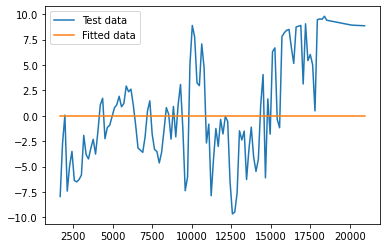

In [295]:
from scipy.optimize import curve_fit
import sys

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [np.mean(n),np.std(n), 1.]

coeff, var_matrix = curve_fit(gauss, a, n, p0=p0)

# Get the fitted curve
f1 = gauss(a, *coeff)

plt.plot(a,n, label='Test data')

plt.plot(a,f1, label='Fitted data')
"""plt.plot(a,n-f1,label="D2")
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff[1])
print('Fitted standard deviation = ', coeff[2])

n_=n-f1
p0 = [np.mean(n_), np.std(n_), 1.]
coeff, var_matrix = curve_fit(gauss, a, n_, p0=p0)
f2 = gauss(a, *coeff)

plt.plot(a,f2, label='Fitted data 2')"""


plt.legend()

In [294]:
a=alts
n=[]
for v in n_diffs.values:
    n.append(v[0])
n=np.array(n)

In [293]:
n

array([-7.94479136, -2.74239437,  0.05436896, -7.41867455, -4.93905882,
       -3.51118525, -6.36900501, -6.51151243, -6.27579954, -5.84509663,
       -1.93123424, -3.83580296, -4.25126723, -3.19510482, -2.32237455,
       -3.77158538, -1.54538614,  1.05709569,  1.72488884, -2.25860923,
       -1.14436599, -0.93104132, -0.06334512,  0.77889919,  1.08499548,
        1.91579357,  0.88417731,  1.21309583,  2.92951982,  2.36237182,
        2.61711698,  1.03238146, -0.92574633, -3.18040824, -3.38444181,
       -3.60039203, -2.06641148,  0.45273828,  1.47118236, -1.81750845,
       -3.30727818, -3.52200827, -4.64429545, -3.59403816, -1.4527475 ,
        0.79755303,  0.1398287 , -2.30090388,  0.91251434, -2.07458224,
        1.09509143,  3.0772244 , -1.29232549, -7.37633171, -6.0123591 ,
        5.02977284,  8.89305924,  7.74382049,  3.23423204,  2.9692358 ,
        7.07423661,  4.72171448, -2.67896113, -0.82195202, -7.87368453,
       -4.23178069, -1.25709605, -3.01982801, -0.36231469, -1.78

In [ ]:
plt.plot(a, n, label='data')
plt.plot(a, gauss(a, *gauss_fit(a, n)), '--r', label='fit')

plt.plot(a, gauss(a, *gauss_fit(a, n))+gauss(a, *gauss_fit(a, n_new)), label='fit2')
plt.legend()
plt.title('Gaussian fit,  $f(x) = A e^{(-(x-x_0)^2/(2sigma^2))}$')
plt.xlabel('Motor position')
plt.ylabel('Intensity (A)')
plt.show()

In [108]:
gauss(a, *gauss_fit(a, n_new))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([nan, nan, nan, ..., nan, nan, nan])

In [181]:
data

[<iris 'Cube' of cloud_mixing_ratio / (kg kg-1) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 24; latitude: 361; longitude: 720)>,
<iris 'Cube' of cloud_area_fraction_assuming_maximum_random_overlap / (1) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of cloud_mixing_ratio / (kg kg-1) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 22; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 21; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (pressure: 19; latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of unknown / (unknown) (latitude: 361; longitude: 720)>,
<iris 'Cube' of convective_inhibition / (J kg-1) (latitude: 361; longitude: 720)>,
<iris 'Cube' of conv

array([[0.000e+00, 1.000e+01, 2.000e+01, ..., 2.497e+04, 2.498e+04,
        2.499e+04]])

array([[ -7.2902156 , -11.45979426, -11.28280191,  -8.99897121],
       [ -7.38705197, -11.5060765 , -11.36622496,  -9.06594148],
       [ -7.48388834, -11.55235874, -11.44964801,  -9.13291175],
       ...,
       [-11.14721885, -10.63331533, -12.13741817, -13.91179335],
       [-11.16880456, -10.64625591, -12.1595199 , -13.94228783],
       [-11.19039027, -10.65919649, -12.18162163, -13.9727823 ]])